<a href="https://colab.research.google.com/github/esihsi/colab-ML/blob/main/DDPM_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class DDPMScheduler:
    """Beta schedule and diffusion utilities for DDPM"""

    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, schedule="cosine"):
        self.num_timesteps = num_timesteps
        if schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        elif schedule == "cosine":
            # Cosine schedule (Nichol & Dhariwal, 2021)
            # Better for image generation, prevents "static" artifacts
            steps = num_timesteps + 1
            x = torch.linspace(0, num_timesteps, steps)
            alphas_cumprod = torch.cos(((x / num_timesteps) + 0.008) / (1 + 0.008) * torch.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            self.betas = torch.clip(betas, 0.0001, 0.9999)

        # Calculate alphas
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

    def add_noise(self, x_0, t, noise=None):
        """Forward diffusion process: q(x_t | x_0)"""
        if noise is None:
            noise = torch.randn_like(x_0)

        # Reshape to allow broadcasting across feature dimensions
        # For 2D data (batch_size, 2) it becomes (batch_size, 1)
        # For image data (batch_size, 1, H, W) it becomes (batch_size, 1, 1, 1)
        reshape_dims = (x_0.shape[0],) + (1,) * (len(x_0.shape) - 1)

        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].view(reshape_dims)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(reshape_dims)

        # x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
        return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise, noise



In [ ]:
#==============================================================================
# PART 2: NEURAL NETWORK ARCHITECTURES
#==============================================================================

class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal time embeddings"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleMLP(nn.Module):
    """Simple MLP for 2D data denoising"""

    def __init__(self, input_dim=2, hidden_dim=128, time_dim=64):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.network = nn.Sequential(
            nn.Linear(input_dim + time_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        x = torch.cat([x, t_emb], dim=-1)
        return self.network(x)


In [ ]:
import torch
import torch.nn as nn
import numpy as np

class DiTBlock(nn.Module):
    """
    A Transformer block with Adaptive Layer Norm (AdaLN).
    This is the core component of modern Diffusion Transformers (like Sora).
    """
    def __init__(self, hidden_size, num_heads, time_emb_dim, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)

        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, hidden_size),
        )

        # AdaLN: Regress shift (gamma) and scale (beta) from the time embedding
        # We output 6 parameters: shift/scale/gate for Attention, shift/scale/gate for MLP
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, 6 * hidden_size, bias=True)
        )

    def forward(self, x, t):
        # 1. Calculate modulation parameters from time t
        # chunk(6) splits the output into 6 parts
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = \
            self.adaLN_modulation(t).chunk(6, dim=1)

        # 2. Attention Block with Modulation
        # x_mod = norm(x) * (1 + scale) + shift
        x_mod = self.norm1(x) * (1 + scale_msa.unsqueeze(1)) + shift_msa.unsqueeze(1)
        x_attn, _ = self.attn(x_mod, x_mod, x_mod)
        x = x + gate_msa.unsqueeze(1) * x_attn

        # 3. MLP Block with Modulation
        x_mod = self.norm2(x) * (1 + scale_mlp.unsqueeze(1)) + shift_mlp.unsqueeze(1)
        x_mlp = self.mlp(x_mod)
        x = x + gate_mlp.unsqueeze(1) * x_mlp

        return x

class MiniDiT(nn.Module):
    """
    Corrected MiniDiT with proper initialization and Positional Embeddings.
    """
    def __init__(self,
                 in_channels=1,
                 patch_size=2,
                 hidden_size=256,
                 depth=8,
                 num_heads=4,
                 time_emb_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels

        # 1. Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # 2. Patch Embedding
        self.patch_embed = nn.Conv2d(in_channels, hidden_size,
                                     kernel_size=patch_size, stride=patch_size)

        # 3. Positional Embedding (FIXED: Random Init, not Zeros)
        num_patches = (28 // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, hidden_size) * 0.02)

        # 4. Transformer Blocks
        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, time_emb_dim) for _ in range(depth)
        ])

        # 5. Final Layer
        self.final_norm = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.final_adaLN = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, 2 * hidden_size))
        self.final_linear = nn.Linear(hidden_size, patch_size * patch_size * in_channels)

        # 6. Apply Weight Initialization (CRITICAL FOR DiT)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        # Zero-out the last layer of AdaLN modulation (DiT Trick)
        # This makes the block act as Identity at the start of training
        if isinstance(m, DiTBlock):
            # The adaLN_modulation last layer is the 2nd Linear layer in the Sequential
            nn.init.constant_(m.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(m.adaLN_modulation[-1].bias, 0)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        # Patchify
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        # Add Positional Embeddings
        x = x + self.pos_embed

        for block in self.blocks:
            x = block(x, t_emb)

        # Unpatchify
        shift, scale = self.final_adaLN(t_emb).chunk(2, dim=1)
        x = self.final_norm(x) * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)
        x = self.final_linear(x)

        # Reshape logic
        B, N, _ = x.shape
        grid = int(N**0.5)
        x = x.view(B, grid, grid, self.patch_size, self.patch_size, self.in_channels)
        x = x.permute(0, 5, 1, 3, 2, 4)
        x = x.reshape(B, self.in_channels, 28, 28)

        return x

In [ ]:
class SmoothDecoder(nn.Module):
    """
    CNN Decoder to upsample latent features smoothly.
    Replaces the "cookie-cutter" linear patch projection.
    """
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            # Layer 1: Refine features at 14x14
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.GroupNorm(8, in_channels // 2),
            nn.SiLU(),

            # Layer 2: Upsample 14x14 -> 28x28
            # ConvTranspose2d is a "Learnable Upsample"
            nn.ConvTranspose2d(in_channels // 2, in_channels // 4,
                               kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(4, in_channels // 4),
            nn.SiLU(),

            # Layer 3: Final smoothing and projection to 1 channel
            nn.Conv2d(in_channels // 4, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

class MiniDiT_Smooth(nn.Module):
    """
    MiniDiT with a VAE-style Convolutional Decoder for smooth output.
    """
    def __init__(self,
                 in_channels=1,
                 patch_size=2,
                 hidden_size=256,
                 depth=4, # Kept at 4 as per previous optimization
                 num_heads=4,
                 time_emb_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels

        # 1. Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # 2. Patch Embedding
        self.patch_embed = nn.Conv2d(in_channels, hidden_size,
                                     kernel_size=patch_size, stride=patch_size)

        # 3. Positional Embedding
        num_patches = (28 // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, hidden_size) * 0.02)

        # 4. Transformer Blocks
        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, time_emb_dim) for _ in range(depth)
        ])

        # 5. Final Norm & AdaLN (Conditioning)
        self.final_norm = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.final_adaLN = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, 2 * hidden_size))

        # 6. REPLACEMENT: The Convolutional Decoder instead of Linear
        self.decoder = SmoothDecoder(hidden_size, in_channels)

        # 7. Init Weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        if isinstance(m, DiTBlock):
            nn.init.constant_(m.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(m.adaLN_modulation[-1].bias, 0)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        # Patchify
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        # Add Positional Embeddings
        x = x + self.pos_embed

        for block in self.blocks:
            x = block(x, t_emb)

        # Unpatchify Logic (Modified for Smoothness)

        # 1. Apply AdaLN conditioning as usual
        shift, scale = self.final_adaLN(t_emb).chunk(2, dim=1)
        x = self.final_norm(x) * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

        # 2. Reshape from Sequence (B, N, C) back to Grid (B, C, H, W)
        B, N, C = x.shape
        grid_size = int(N**0.5) # Should be 14 for patch_size=2
        x = x.transpose(1, 2).view(B, C, grid_size, grid_size)

        # 3. Pass through CNN Decoder to get smooth (B, 1, 28, 28)
        x = self.decoder(x)

        return x

In [ ]:
#==============================================================================
# PART 3: DATASET GENERATORS
#==============================================================================

class Synthetic2DDataset(Dataset):
    """2D Synthetic dataset: y = x/||x|| where x ~ N(0, I)"""

    def __init__(self, num_samples=10000):
        # Sample from N(0, I)
        x = np.random.randn(num_samples, 2)

        # Normalize to unit circle: y = x / ||x||
        norms = np.linalg.norm(x, axis=1, keepdims=True)
        y = x / norms

        self.data = torch.FloatTensor(y)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def get_mnist_dataloader(batch_size=256, train=True):
    """Load MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    dataset = datasets.MNIST(
        root='./data',
        train=train,
        download=True,
        transform=transform
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=train,
        num_workers=2
    )

    return dataloader


In [ ]:
class EMA:
    """
    Exponential Moving Average for model parameters.
    References: https://github.com/lucidrains/ema-pytorch
    """
    def __init__(self, beta=0.995):
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [ ]:
#==============================================================================
# PART 4: TRAINING FUNCTIONS
#==============================================================================

import copy

def train_ddpm(model, dataloader, scheduler, num_epochs, lr, experiment):
    """Train DDPM model with EMA"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    # --- EMA SETUP ---
    # Create a copy of the model for EMA
    ema = EMA(beta=0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)
    # -----------------

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in pbar:
            if isinstance(batch, list):
                x_0 = batch[0].to(device)
            else:
                x_0 = batch.to(device)

            t = torch.randint(0, scheduler.num_timesteps, (x_0.shape[0],), device=device)
            noise = torch.randn_like(x_0)
            x_t, _ = scheduler.add_noise(x_0, t, noise)

            # Predict noise
            predicted_noise = model(x_t, t)
            loss = F.mse_loss(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # --- UPDATE EMA ---
            ema.step_ema(ema_model, model)
            # ------------------

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.6f}")
        # ============================================================
        # CHECKPOINT LOGIC: AT EPOCH 100
        # ============================================================
        if (epoch + 1) == 100 and experiment != '2d':
            print(f"\n\n>>> EPOCH 100 REACHED. Saving Checkpoint and Generating Samples... <<<")

            # 1. Save the EMA model weights
            torch.save(ema_model.state_dict(), "model_epoch_100.pth")
            print("✓ Model saved to 'model_epoch_100.pth'")

            # 2. Generate and Show Digits (In-line)
            # We call the visualization function directly here
            visualize_mnist_results(ema_model, scheduler, num_samples=16)
            visualize_mnist_denoising_process(ema_model, scheduler)

            print(">>> Resuming training to 200...\n")
        # ============================================================

    # Return the EMA model instead of the raw model
    return losses, ema_model

In [ ]:
#==============================================================================
# PART 5: SAMPLING FUNCTIONS
#==============================================================================

@torch.no_grad()
def sample_ddpm(model, scheduler, shape, num_samples=1, save_trajectory=False):
    """
    Corrected Reverse diffusion sampling (Algorithm 2 from Ho et al. 2020)
    """
    model.eval()

    # 1. Start from pure noise x_T
    x = torch.randn(num_samples, *shape).to(device)

    trajectory = [x.cpu().numpy()] if save_trajectory else []

    # 2. Reverse process: x_T -> x_{T-1} -> ... -> x_0
    for t in reversed(range(scheduler.num_timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Predict noise noise_theta
        predicted_noise = model(x, t_batch)

        # Get diffusion parameters for this step
        beta_t = scheduler.betas[t]
        alpha_t = scheduler.alphas[t]
        alpha_bar_t = scheduler.alphas_cumprod[t]

        # 3. Calculate the Mean (mu_theta)
        # Formula: 1/sqrt(alpha_t) * (x_t - (beta_t / sqrt(1 - alpha_bar_t)) * predicted_noise)

        # We need 1 / sqrt(alpha_t)
        coeff1 = 1 / torch.sqrt(alpha_t)

        # We need beta_t / sqrt(1 - alpha_bar_t)
        coeff2 = beta_t / torch.sqrt(1 - alpha_bar_t)

        # Combine to get the mean
        mu_theta = coeff1 * (x - coeff2 * predicted_noise)

        # 4. Add Noise (sigma_t * z)
        # Use beta_t as the variance (Option 1 in the paper)
        if t > 0:
            noise = torch.randn_like(x)
            #sigma_t = torch.sqrt(beta_t)
            posterior_variance_t = scheduler.posterior_variance[t]
            sigma_t = torch.sqrt(posterior_variance_t)
            x = mu_theta + sigma_t * noise
        else:
            x = mu_theta # No noise at the final step

        if save_trajectory and t % 100 == 0:
            trajectory.append(x.cpu().numpy())

    if save_trajectory:
        return x.cpu().numpy(), trajectory
    return x.cpu().numpy()

In [ ]:
import numpy as np

#==============================================================================
# PART 6: VISUALIZATION FUNCTIONS
#==============================================================================

def visualize_2d_results(model, scheduler, dataset, num_samples=1000):
    """Visualize 2D synthetic data results"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Original data distribution
    original_data = dataset.data.numpy()
    axes[0].scatter(original_data[:, 0], original_data[:, 1],
                   alpha=0.5, s=10, c='blue', label='Original Data')
    axes[0].set_title('Original Data Distribution (Unit Circle)', fontsize=14)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].axis('equal')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot 2: Generated samples
    generated_samples = sample_ddpm(model, scheduler, shape=(2,), num_samples=num_samples)
    axes[1].scatter(generated_samples[:, 0], generated_samples[:, 1],
                   alpha=0.5, s=10, c='red', label='Generated Samples')
    axes[1].set_title('Generated Samples', fontsize=14)
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].axis('equal')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # Plot 3: Overlay
    axes[2].scatter(original_data[:500, 0], original_data[:500, 1],
                   alpha=0.3, s=10, c='blue', label='Original')
    axes[2].scatter(generated_samples[:500, 0], generated_samples[:500, 1],
                   alpha=0.3, s=10, c='red', label='Generated')
    axes[2].set_title('Overlay Comparison', fontsize=14)
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    axes[2].axis('equal')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


def visualize_denoising_trajectory(model, scheduler, num_trajectories=5):
    """Visualize denoising trajectories for 2D data"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    colors = plt.cm.viridis(np.linspace(0, 1, num_trajectories))

    for i in range(num_trajectories):
        _, trajectory = sample_ddpm(model, scheduler, shape=(2,),
                                   num_samples=1, save_trajectory=True)
        trajectory = np.array(trajectory).squeeze()

        # Plot trajectory
        axes[0].plot(trajectory[:, 0], trajectory[:, 1],
                    alpha=0.7, linewidth=2, color=colors[i])
        axes[0].scatter(trajectory[0, 0], trajectory[0, 1],
                       s=100, c=[colors[i]], marker='o', edgecolors='black',
                       linewidths=2, label=f'Start {i+1}')
        axes[0].scatter(trajectory[-1, 0], trajectory[-1, 1],
                       s=100, c=[colors[i]], marker='*', edgecolors='black',
                       linewidths=2)

    axes[0].set_title('Denoising Trajectories (Noise \u2192 Data)', fontsize=14)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].axis('equal')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot distance to origin over time
    for i in range(num_trajectories):
        _, trajectory = sample_ddpm(model, scheduler, shape=(2,),
                                   num_samples=1, save_trajectory=True)
        trajectory = np.array(trajectory).squeeze()
        distances = np.linalg.norm(trajectory, axis=1)
        axes[1].plot(distances, alpha=0.7, linewidth=2, color=colors[i])

    axes[1].set_title('Distance to Origin Over Denoising Steps', fontsize=14)
    axes[1].set_xlabel('Denoising Step')
    axes[1].set_ylabel('Distance to Origin')
    axes[1].axhline(y=1, color='red', linestyle='--', label='Target (Unit Circle)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


def visualize_mnist_results(model, scheduler, num_samples=16):
    """Visualize MNIST generation results"""
    samples = sample_ddpm(model, scheduler, shape=(1, 28, 28), num_samples=num_samples)

    # Denormalize from [-1, 1] to [0, 1]
    samples = (samples + 1) / 2
    samples = np.clip(samples, 0, 1)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_samples):
        axes[i].imshow(samples[i, 0], cmap='gray')
        axes[i].axis('off')

    plt.suptitle('Generated MNIST Digits', fontsize=16)
    plt.tight_layout()
    plt.show()


def visualize_mnist_denoising_process(model, scheduler):
    """Visualize the denoising process for a single MNIST sample"""
    _, trajectory = sample_ddpm(model, scheduler, shape=(1, 28, 28),
                               num_samples=1, save_trajectory=True)

    # Select evenly spaced frames
    num_frames = min(10, len(trajectory))
    indices = np.linspace(0, len(trajectory)-1, num_frames, dtype=int)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        img = trajectory[idx][0, 0]
        img = (img + 1) / 2  # Denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Step {idx}')
        axes[i].axis('off')

    plt.suptitle('MNIST Denoising Process (Noise \u2192 Digit)', fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_training_losses(losses):
    """Plot training losses"""
    if not losses:
        print("Warning: No losses to plot. The 'losses' list was empty.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(losses, linewidth=2)
    plt.title('Training Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


DENOISING DIFFUSION PROBABILISTIC MODEL (DDPM)
Implementation for 2D Synthetic Data and MNIST

EXPERIMENT 1: 2D SYNTHETIC DATA (Unit Circle)

1. Creating 2D synthetic dataset...
2. Initializing model and scheduler...
3. Training model...


Epoch 1/200: 100%|██████████| 391/391 [00:01<00:00, 245.04it/s, loss=0.384]


Epoch 1: Average Loss = 0.426556


Epoch 2/200: 100%|██████████| 391/391 [00:01<00:00, 238.28it/s, loss=0.423]


Epoch 2: Average Loss = 0.343867


Epoch 3/200: 100%|██████████| 391/391 [00:01<00:00, 245.38it/s, loss=0.315]


Epoch 3: Average Loss = 0.326631


Epoch 4/200: 100%|██████████| 391/391 [00:01<00:00, 241.34it/s, loss=0.297]


Epoch 4: Average Loss = 0.316611


Epoch 5/200: 100%|██████████| 391/391 [00:01<00:00, 240.28it/s, loss=0.327]


Epoch 5: Average Loss = 0.317212


Epoch 6/200: 100%|██████████| 391/391 [00:01<00:00, 231.58it/s, loss=0.302]


Epoch 6: Average Loss = 0.312337


Epoch 7/200: 100%|██████████| 391/391 [00:01<00:00, 239.31it/s, loss=0.37]


Epoch 7: Average Loss = 0.312820


Epoch 8/200: 100%|██████████| 391/391 [00:01<00:00, 233.39it/s, loss=0.267]


Epoch 8: Average Loss = 0.313583


Epoch 9/200: 100%|██████████| 391/391 [00:01<00:00, 233.24it/s, loss=0.264]


Epoch 9: Average Loss = 0.310017


Epoch 10/200: 100%|██████████| 391/391 [00:01<00:00, 234.40it/s, loss=0.239]


Epoch 10: Average Loss = 0.309363


Epoch 11/200: 100%|██████████| 391/391 [00:01<00:00, 235.75it/s, loss=0.376]


Epoch 11: Average Loss = 0.308858


Epoch 12/200: 100%|██████████| 391/391 [00:01<00:00, 231.36it/s, loss=0.344]


Epoch 12: Average Loss = 0.307770


Epoch 13/200: 100%|██████████| 391/391 [00:01<00:00, 232.80it/s, loss=0.352]


Epoch 13: Average Loss = 0.309332


Epoch 14/200: 100%|██████████| 391/391 [00:01<00:00, 238.10it/s, loss=0.225]


Epoch 14: Average Loss = 0.307413


Epoch 15/200: 100%|██████████| 391/391 [00:01<00:00, 235.53it/s, loss=0.285]


Epoch 15: Average Loss = 0.307588


Epoch 16/200: 100%|██████████| 391/391 [00:01<00:00, 234.46it/s, loss=0.378]


Epoch 16: Average Loss = 0.306917


Epoch 17/200: 100%|██████████| 391/391 [00:01<00:00, 237.65it/s, loss=0.404]


Epoch 17: Average Loss = 0.307155


Epoch 18/200: 100%|██████████| 391/391 [00:01<00:00, 239.42it/s, loss=0.267]


Epoch 18: Average Loss = 0.304879


Epoch 19/200: 100%|██████████| 391/391 [00:01<00:00, 234.09it/s, loss=0.291]


Epoch 19: Average Loss = 0.306316


Epoch 20/200: 100%|██████████| 391/391 [00:01<00:00, 233.36it/s, loss=0.285]


Epoch 20: Average Loss = 0.304508


Epoch 21/200: 100%|██████████| 391/391 [00:01<00:00, 236.46it/s, loss=0.267]


Epoch 21: Average Loss = 0.307654


Epoch 22/200: 100%|██████████| 391/391 [00:01<00:00, 235.02it/s, loss=0.277]


Epoch 22: Average Loss = 0.304742


Epoch 23/200: 100%|██████████| 391/391 [00:01<00:00, 237.27it/s, loss=0.314]


Epoch 23: Average Loss = 0.304153


Epoch 24/200: 100%|██████████| 391/391 [00:01<00:00, 237.37it/s, loss=0.299]


Epoch 24: Average Loss = 0.305454


Epoch 25/200: 100%|██████████| 391/391 [00:01<00:00, 235.23it/s, loss=0.298]


Epoch 25: Average Loss = 0.303508


Epoch 26/200: 100%|██████████| 391/391 [00:01<00:00, 235.36it/s, loss=0.274]


Epoch 26: Average Loss = 0.304455


Epoch 27/200: 100%|██████████| 391/391 [00:01<00:00, 236.06it/s, loss=0.301]


Epoch 27: Average Loss = 0.303643


Epoch 28/200: 100%|██████████| 391/391 [00:01<00:00, 236.84it/s, loss=0.258]


Epoch 28: Average Loss = 0.304783


Epoch 29/200: 100%|██████████| 391/391 [00:01<00:00, 233.56it/s, loss=0.42]


Epoch 29: Average Loss = 0.305996


Epoch 30/200: 100%|██████████| 391/391 [00:01<00:00, 236.38it/s, loss=0.283]


Epoch 30: Average Loss = 0.306162


Epoch 31/200: 100%|██████████| 391/391 [00:01<00:00, 237.05it/s, loss=0.342]


Epoch 31: Average Loss = 0.303290


Epoch 32/200: 100%|██████████| 391/391 [00:01<00:00, 235.74it/s, loss=0.269]


Epoch 32: Average Loss = 0.302304


Epoch 33/200: 100%|██████████| 391/391 [00:01<00:00, 234.01it/s, loss=0.233]


Epoch 33: Average Loss = 0.302693


Epoch 34/200: 100%|██████████| 391/391 [00:01<00:00, 233.98it/s, loss=0.378]


Epoch 34: Average Loss = 0.301710


Epoch 35/200: 100%|██████████| 391/391 [00:01<00:00, 234.72it/s, loss=0.282]


Epoch 35: Average Loss = 0.303300


Epoch 36/200: 100%|██████████| 391/391 [00:01<00:00, 233.30it/s, loss=0.309]


Epoch 36: Average Loss = 0.303799


Epoch 37/200: 100%|██████████| 391/391 [00:01<00:00, 237.30it/s, loss=0.337]


Epoch 37: Average Loss = 0.303369


Epoch 38/200: 100%|██████████| 391/391 [00:01<00:00, 237.35it/s, loss=0.338]


Epoch 38: Average Loss = 0.306173


Epoch 39/200: 100%|██████████| 391/391 [00:01<00:00, 240.05it/s, loss=0.243]


Epoch 39: Average Loss = 0.303896


Epoch 40/200: 100%|██████████| 391/391 [00:01<00:00, 240.12it/s, loss=0.281]


Epoch 40: Average Loss = 0.302527


Epoch 41/200: 100%|██████████| 391/391 [00:01<00:00, 236.14it/s, loss=0.326]


Epoch 41: Average Loss = 0.303440


Epoch 42/200: 100%|██████████| 391/391 [00:01<00:00, 236.65it/s, loss=0.276]


Epoch 42: Average Loss = 0.303075


Epoch 43/200: 100%|██████████| 391/391 [00:01<00:00, 238.88it/s, loss=0.265]


Epoch 43: Average Loss = 0.303258


Epoch 44/200: 100%|██████████| 391/391 [00:01<00:00, 238.97it/s, loss=0.254]


Epoch 44: Average Loss = 0.300480


Epoch 45/200: 100%|██████████| 391/391 [00:01<00:00, 235.81it/s, loss=0.345]


Epoch 45: Average Loss = 0.302290


Epoch 46/200: 100%|██████████| 391/391 [00:01<00:00, 239.30it/s, loss=0.352]


Epoch 46: Average Loss = 0.303425


Epoch 47/200: 100%|██████████| 391/391 [00:01<00:00, 235.14it/s, loss=0.344]


Epoch 47: Average Loss = 0.303904


Epoch 48/200: 100%|██████████| 391/391 [00:01<00:00, 234.52it/s, loss=0.25]


Epoch 48: Average Loss = 0.302565


Epoch 49/200: 100%|██████████| 391/391 [00:01<00:00, 234.94it/s, loss=0.315]


Epoch 49: Average Loss = 0.305348


Epoch 50/200: 100%|██████████| 391/391 [00:01<00:00, 237.15it/s, loss=0.353]


Epoch 50: Average Loss = 0.305141


Epoch 51/200: 100%|██████████| 391/391 [00:01<00:00, 239.57it/s, loss=0.229]


Epoch 51: Average Loss = 0.304101


Epoch 52/200: 100%|██████████| 391/391 [00:01<00:00, 236.03it/s, loss=0.365]


Epoch 52: Average Loss = 0.300068


Epoch 53/200: 100%|██████████| 391/391 [00:01<00:00, 236.91it/s, loss=0.389]


Epoch 53: Average Loss = 0.300687


Epoch 54/200: 100%|██████████| 391/391 [00:01<00:00, 234.63it/s, loss=0.335]


Epoch 54: Average Loss = 0.302144


Epoch 55/200: 100%|██████████| 391/391 [00:01<00:00, 238.70it/s, loss=0.341]


Epoch 55: Average Loss = 0.303313


Epoch 56/200: 100%|██████████| 391/391 [00:01<00:00, 239.23it/s, loss=0.276]


Epoch 56: Average Loss = 0.304463


Epoch 57/200: 100%|██████████| 391/391 [00:01<00:00, 238.63it/s, loss=0.304]


Epoch 57: Average Loss = 0.302924


Epoch 58/200: 100%|██████████| 391/391 [00:01<00:00, 240.69it/s, loss=0.255]


Epoch 58: Average Loss = 0.304799


Epoch 59/200: 100%|██████████| 391/391 [00:01<00:00, 237.29it/s, loss=0.3]


Epoch 59: Average Loss = 0.303978


Epoch 60/200: 100%|██████████| 391/391 [00:01<00:00, 234.91it/s, loss=0.319]


Epoch 60: Average Loss = 0.303333


Epoch 61/200: 100%|██████████| 391/391 [00:01<00:00, 232.66it/s, loss=0.313]


Epoch 61: Average Loss = 0.305639


Epoch 62/200: 100%|██████████| 391/391 [00:01<00:00, 239.21it/s, loss=0.326]


Epoch 62: Average Loss = 0.301725


Epoch 63/200: 100%|██████████| 391/391 [00:01<00:00, 236.85it/s, loss=0.288]


Epoch 63: Average Loss = 0.305892


Epoch 64/200: 100%|██████████| 391/391 [00:01<00:00, 235.43it/s, loss=0.316]


Epoch 64: Average Loss = 0.301764


Epoch 65/200: 100%|██████████| 391/391 [00:01<00:00, 238.11it/s, loss=0.3]


Epoch 65: Average Loss = 0.302009


Epoch 66/200: 100%|██████████| 391/391 [00:01<00:00, 238.59it/s, loss=0.306]


Epoch 66: Average Loss = 0.300984


Epoch 67/200: 100%|██████████| 391/391 [00:01<00:00, 237.77it/s, loss=0.26]


Epoch 67: Average Loss = 0.300614


Epoch 68/200: 100%|██████████| 391/391 [00:01<00:00, 231.04it/s, loss=0.235]


Epoch 68: Average Loss = 0.301658


Epoch 69/200: 100%|██████████| 391/391 [00:01<00:00, 235.86it/s, loss=0.217]


Epoch 69: Average Loss = 0.304965


Epoch 70/200: 100%|██████████| 391/391 [00:01<00:00, 235.16it/s, loss=0.361]


Epoch 70: Average Loss = 0.300746


Epoch 71/200: 100%|██████████| 391/391 [00:01<00:00, 237.59it/s, loss=0.326]


Epoch 71: Average Loss = 0.304724


Epoch 72/200: 100%|██████████| 391/391 [00:01<00:00, 239.38it/s, loss=0.278]


Epoch 72: Average Loss = 0.305501


Epoch 73/200: 100%|██████████| 391/391 [00:01<00:00, 240.26it/s, loss=0.316]


Epoch 73: Average Loss = 0.300670


Epoch 74/200: 100%|██████████| 391/391 [00:01<00:00, 238.26it/s, loss=0.302]


Epoch 74: Average Loss = 0.298995


Epoch 75/200: 100%|██████████| 391/391 [00:01<00:00, 230.33it/s, loss=0.274]


Epoch 75: Average Loss = 0.303294


Epoch 76/200: 100%|██████████| 391/391 [00:01<00:00, 240.76it/s, loss=0.312]


Epoch 76: Average Loss = 0.303106


Epoch 77/200: 100%|██████████| 391/391 [00:01<00:00, 238.36it/s, loss=0.252]


Epoch 77: Average Loss = 0.300113


Epoch 78/200: 100%|██████████| 391/391 [00:01<00:00, 238.11it/s, loss=0.364]


Epoch 78: Average Loss = 0.299791


Epoch 79/200: 100%|██████████| 391/391 [00:01<00:00, 236.35it/s, loss=0.331]


Epoch 79: Average Loss = 0.301998


Epoch 80/200: 100%|██████████| 391/391 [00:01<00:00, 227.21it/s, loss=0.304]


Epoch 80: Average Loss = 0.304215


Epoch 81/200: 100%|██████████| 391/391 [00:01<00:00, 233.57it/s, loss=0.248]


Epoch 81: Average Loss = 0.299901


Epoch 82/200: 100%|██████████| 391/391 [00:01<00:00, 231.00it/s, loss=0.318]


Epoch 82: Average Loss = 0.303495


Epoch 83/200: 100%|██████████| 391/391 [00:01<00:00, 236.77it/s, loss=0.345]


Epoch 83: Average Loss = 0.301807


Epoch 84/200: 100%|██████████| 391/391 [00:01<00:00, 236.14it/s, loss=0.302]


Epoch 84: Average Loss = 0.301002


Epoch 85/200: 100%|██████████| 391/391 [00:01<00:00, 238.43it/s, loss=0.288]


Epoch 85: Average Loss = 0.303100


Epoch 86/200: 100%|██████████| 391/391 [00:01<00:00, 238.23it/s, loss=0.359]


Epoch 86: Average Loss = 0.301117


Epoch 87/200: 100%|██████████| 391/391 [00:01<00:00, 237.00it/s, loss=0.296]


Epoch 87: Average Loss = 0.298337


Epoch 88/200: 100%|██████████| 391/391 [00:01<00:00, 238.03it/s, loss=0.24]


Epoch 88: Average Loss = 0.302814


Epoch 89/200: 100%|██████████| 391/391 [00:01<00:00, 227.31it/s, loss=0.244]


Epoch 89: Average Loss = 0.299815


Epoch 90/200: 100%|██████████| 391/391 [00:01<00:00, 233.42it/s, loss=0.295]


Epoch 90: Average Loss = 0.302469


Epoch 91/200: 100%|██████████| 391/391 [00:01<00:00, 236.58it/s, loss=0.296]


Epoch 91: Average Loss = 0.304289


Epoch 92/200: 100%|██████████| 391/391 [00:01<00:00, 235.89it/s, loss=0.205]


Epoch 92: Average Loss = 0.304716


Epoch 93/200: 100%|██████████| 391/391 [00:01<00:00, 234.04it/s, loss=0.273]


Epoch 93: Average Loss = 0.302091


Epoch 94/200: 100%|██████████| 391/391 [00:01<00:00, 236.05it/s, loss=0.371]


Epoch 94: Average Loss = 0.301475


Epoch 95/200: 100%|██████████| 391/391 [00:01<00:00, 238.01it/s, loss=0.292]


Epoch 95: Average Loss = 0.305800


Epoch 96/200: 100%|██████████| 391/391 [00:01<00:00, 227.26it/s, loss=0.266]


Epoch 96: Average Loss = 0.303657


Epoch 97/200: 100%|██████████| 391/391 [00:01<00:00, 236.88it/s, loss=0.253]


Epoch 97: Average Loss = 0.300693


Epoch 98/200: 100%|██████████| 391/391 [00:01<00:00, 235.24it/s, loss=0.263]


Epoch 98: Average Loss = 0.301688


Epoch 99/200: 100%|██████████| 391/391 [00:01<00:00, 235.24it/s, loss=0.343]


Epoch 99: Average Loss = 0.300969


Epoch 100/200: 100%|██████████| 391/391 [00:01<00:00, 235.01it/s, loss=0.321]


Epoch 100: Average Loss = 0.303368


Epoch 101/200: 100%|██████████| 391/391 [00:01<00:00, 238.05it/s, loss=0.346]


Epoch 101: Average Loss = 0.300332


Epoch 102/200: 100%|██████████| 391/391 [00:01<00:00, 233.98it/s, loss=0.333]


Epoch 102: Average Loss = 0.300450


Epoch 103/200: 100%|██████████| 391/391 [00:01<00:00, 222.04it/s, loss=0.352]


Epoch 103: Average Loss = 0.305012


Epoch 104/200: 100%|██████████| 391/391 [00:01<00:00, 234.75it/s, loss=0.376]


Epoch 104: Average Loss = 0.302789


Epoch 105/200: 100%|██████████| 391/391 [00:01<00:00, 235.90it/s, loss=0.276]


Epoch 105: Average Loss = 0.301473


Epoch 106/200: 100%|██████████| 391/391 [00:01<00:00, 234.13it/s, loss=0.271]


Epoch 106: Average Loss = 0.303725


Epoch 107/200: 100%|██████████| 391/391 [00:01<00:00, 235.05it/s, loss=0.299]


Epoch 107: Average Loss = 0.301233


Epoch 108/200: 100%|██████████| 391/391 [00:01<00:00, 233.77it/s, loss=0.381]


Epoch 108: Average Loss = 0.302395


Epoch 109/200: 100%|██████████| 391/391 [00:01<00:00, 235.81it/s, loss=0.363]


Epoch 109: Average Loss = 0.302203


Epoch 110/200: 100%|██████████| 391/391 [00:01<00:00, 231.06it/s, loss=0.301]


Epoch 110: Average Loss = 0.302095


Epoch 111/200: 100%|██████████| 391/391 [00:01<00:00, 233.79it/s, loss=0.321]


Epoch 111: Average Loss = 0.301464


Epoch 112/200: 100%|██████████| 391/391 [00:01<00:00, 234.92it/s, loss=0.322]


Epoch 112: Average Loss = 0.302638


Epoch 113/200: 100%|██████████| 391/391 [00:01<00:00, 236.14it/s, loss=0.267]


Epoch 113: Average Loss = 0.302257


Epoch 114/200: 100%|██████████| 391/391 [00:01<00:00, 235.90it/s, loss=0.284]


Epoch 114: Average Loss = 0.303178


Epoch 115/200: 100%|██████████| 391/391 [00:01<00:00, 236.58it/s, loss=0.268]


Epoch 115: Average Loss = 0.301225


Epoch 116/200: 100%|██████████| 391/391 [00:01<00:00, 231.06it/s, loss=0.326]


Epoch 116: Average Loss = 0.301855


Epoch 117/200: 100%|██████████| 391/391 [00:01<00:00, 230.50it/s, loss=0.323]


Epoch 117: Average Loss = 0.300944


Epoch 118/200: 100%|██████████| 391/391 [00:01<00:00, 235.24it/s, loss=0.328]


Epoch 118: Average Loss = 0.299677


Epoch 119/200: 100%|██████████| 391/391 [00:01<00:00, 237.45it/s, loss=0.348]


Epoch 119: Average Loss = 0.300879


Epoch 120/200: 100%|██████████| 391/391 [00:01<00:00, 234.91it/s, loss=0.279]


Epoch 120: Average Loss = 0.301047


Epoch 121/200: 100%|██████████| 391/391 [00:01<00:00, 236.88it/s, loss=0.254]


Epoch 121: Average Loss = 0.301735


Epoch 122/200: 100%|██████████| 391/391 [00:01<00:00, 236.87it/s, loss=0.314]


Epoch 122: Average Loss = 0.304005


Epoch 123/200: 100%|██████████| 391/391 [00:01<00:00, 229.23it/s, loss=0.291]


Epoch 123: Average Loss = 0.302111


Epoch 124/200: 100%|██████████| 391/391 [00:01<00:00, 233.61it/s, loss=0.275]


Epoch 124: Average Loss = 0.302311


Epoch 125/200: 100%|██████████| 391/391 [00:01<00:00, 233.98it/s, loss=0.286]


Epoch 125: Average Loss = 0.301301


Epoch 126/200: 100%|██████████| 391/391 [00:01<00:00, 237.25it/s, loss=0.304]


Epoch 126: Average Loss = 0.299612


Epoch 127/200: 100%|██████████| 391/391 [00:01<00:00, 237.97it/s, loss=0.297]


Epoch 127: Average Loss = 0.302412


Epoch 128/200: 100%|██████████| 391/391 [00:01<00:00, 231.72it/s, loss=0.269]


Epoch 128: Average Loss = 0.300769


Epoch 129/200: 100%|██████████| 391/391 [00:01<00:00, 237.00it/s, loss=0.366]


Epoch 129: Average Loss = 0.301061


Epoch 130/200: 100%|██████████| 391/391 [00:01<00:00, 232.84it/s, loss=0.382]


Epoch 130: Average Loss = 0.302692


Epoch 131/200: 100%|██████████| 391/391 [00:01<00:00, 235.36it/s, loss=0.305]


Epoch 131: Average Loss = 0.301875


Epoch 132/200: 100%|██████████| 391/391 [00:01<00:00, 235.49it/s, loss=0.351]


Epoch 132: Average Loss = 0.301709


Epoch 133/200: 100%|██████████| 391/391 [00:01<00:00, 232.82it/s, loss=0.253]


Epoch 133: Average Loss = 0.301439


Epoch 134/200: 100%|██████████| 391/391 [00:01<00:00, 235.35it/s, loss=0.326]


Epoch 134: Average Loss = 0.304000


Epoch 135/200: 100%|██████████| 391/391 [00:01<00:00, 231.37it/s, loss=0.295]


Epoch 135: Average Loss = 0.302876


Epoch 136/200: 100%|██████████| 391/391 [00:01<00:00, 234.10it/s, loss=0.281]


Epoch 136: Average Loss = 0.301655


Epoch 137/200: 100%|██████████| 391/391 [00:01<00:00, 230.81it/s, loss=0.271]


Epoch 137: Average Loss = 0.304992


Epoch 138/200: 100%|██████████| 391/391 [00:01<00:00, 233.04it/s, loss=0.312]


Epoch 138: Average Loss = 0.300804


Epoch 139/200: 100%|██████████| 391/391 [00:01<00:00, 234.43it/s, loss=0.303]


Epoch 139: Average Loss = 0.305310


Epoch 140/200: 100%|██████████| 391/391 [00:01<00:00, 235.48it/s, loss=0.324]


Epoch 140: Average Loss = 0.301481


Epoch 141/200: 100%|██████████| 391/391 [00:01<00:00, 232.86it/s, loss=0.237]


Epoch 141: Average Loss = 0.300136


Epoch 142/200: 100%|██████████| 391/391 [00:01<00:00, 231.98it/s, loss=0.309]


Epoch 142: Average Loss = 0.301412


Epoch 143/200: 100%|██████████| 391/391 [00:01<00:00, 235.41it/s, loss=0.279]


Epoch 143: Average Loss = 0.302242


Epoch 144/200: 100%|██████████| 391/391 [00:01<00:00, 229.31it/s, loss=0.233]


Epoch 144: Average Loss = 0.301744


Epoch 145/200: 100%|██████████| 391/391 [00:01<00:00, 232.62it/s, loss=0.267]


Epoch 145: Average Loss = 0.298284


Epoch 146/200: 100%|██████████| 391/391 [00:01<00:00, 232.25it/s, loss=0.322]


Epoch 146: Average Loss = 0.302126


Epoch 147/200: 100%|██████████| 391/391 [00:01<00:00, 232.03it/s, loss=0.3]


Epoch 147: Average Loss = 0.302116


Epoch 148/200: 100%|██████████| 391/391 [00:01<00:00, 233.82it/s, loss=0.238]


Epoch 148: Average Loss = 0.301865


Epoch 149/200: 100%|██████████| 391/391 [00:01<00:00, 234.27it/s, loss=0.273]


Epoch 149: Average Loss = 0.301244


Epoch 150/200: 100%|██████████| 391/391 [00:01<00:00, 232.36it/s, loss=0.353]


Epoch 150: Average Loss = 0.300692


Epoch 151/200: 100%|██████████| 391/391 [00:01<00:00, 226.15it/s, loss=0.275]


Epoch 151: Average Loss = 0.299536


Epoch 152/200: 100%|██████████| 391/391 [00:01<00:00, 234.51it/s, loss=0.36]


Epoch 152: Average Loss = 0.299614


Epoch 153/200: 100%|██████████| 391/391 [00:01<00:00, 232.55it/s, loss=0.277]


Epoch 153: Average Loss = 0.300341


Epoch 154/200: 100%|██████████| 391/391 [00:01<00:00, 233.18it/s, loss=0.287]


Epoch 154: Average Loss = 0.301123


Epoch 155/200: 100%|██████████| 391/391 [00:01<00:00, 233.84it/s, loss=0.328]


Epoch 155: Average Loss = 0.300639


Epoch 156/200: 100%|██████████| 391/391 [00:01<00:00, 235.16it/s, loss=0.367]


Epoch 156: Average Loss = 0.305151


Epoch 157/200: 100%|██████████| 391/391 [00:01<00:00, 232.91it/s, loss=0.363]


Epoch 157: Average Loss = 0.304226


Epoch 158/200: 100%|██████████| 391/391 [00:01<00:00, 226.02it/s, loss=0.234]


Epoch 158: Average Loss = 0.301981


Epoch 159/200: 100%|██████████| 391/391 [00:01<00:00, 233.12it/s, loss=0.401]


Epoch 159: Average Loss = 0.301163


Epoch 160/200: 100%|██████████| 391/391 [00:01<00:00, 237.55it/s, loss=0.315]


Epoch 160: Average Loss = 0.301864


Epoch 161/200: 100%|██████████| 391/391 [00:01<00:00, 231.91it/s, loss=0.323]


Epoch 161: Average Loss = 0.302896


Epoch 162/200: 100%|██████████| 391/391 [00:01<00:00, 234.52it/s, loss=0.29]


Epoch 162: Average Loss = 0.301933


Epoch 163/200: 100%|██████████| 391/391 [00:01<00:00, 235.05it/s, loss=0.318]


Epoch 163: Average Loss = 0.301696


Epoch 164/200: 100%|██████████| 391/391 [00:01<00:00, 232.35it/s, loss=0.337]


Epoch 164: Average Loss = 0.303432


Epoch 165/200: 100%|██████████| 391/391 [00:01<00:00, 229.86it/s, loss=0.29]


Epoch 165: Average Loss = 0.301147


Epoch 166/200: 100%|██████████| 391/391 [00:01<00:00, 234.12it/s, loss=0.296]


Epoch 166: Average Loss = 0.300979


Epoch 167/200: 100%|██████████| 391/391 [00:01<00:00, 234.36it/s, loss=0.337]


Epoch 167: Average Loss = 0.302977


Epoch 168/200: 100%|██████████| 391/391 [00:01<00:00, 232.74it/s, loss=0.379]


Epoch 168: Average Loss = 0.304599


Epoch 169/200: 100%|██████████| 391/391 [00:01<00:00, 234.35it/s, loss=0.297]


Epoch 169: Average Loss = 0.301251


Epoch 170/200: 100%|██████████| 391/391 [00:01<00:00, 232.94it/s, loss=0.288]


Epoch 170: Average Loss = 0.301909


Epoch 171/200: 100%|██████████| 391/391 [00:01<00:00, 230.19it/s, loss=0.326]


Epoch 171: Average Loss = 0.302076


Epoch 172/200: 100%|██████████| 391/391 [00:01<00:00, 233.30it/s, loss=0.355]


Epoch 172: Average Loss = 0.304702


Epoch 173/200: 100%|██████████| 391/391 [00:01<00:00, 232.80it/s, loss=0.271]


Epoch 173: Average Loss = 0.303614


Epoch 174/200: 100%|██████████| 391/391 [00:01<00:00, 233.46it/s, loss=0.338]


Epoch 174: Average Loss = 0.299543


Epoch 175/200: 100%|██████████| 391/391 [00:01<00:00, 234.54it/s, loss=0.282]


Epoch 175: Average Loss = 0.301480


Epoch 176/200: 100%|██████████| 391/391 [00:01<00:00, 231.98it/s, loss=0.347]


Epoch 176: Average Loss = 0.298784


Epoch 177/200: 100%|██████████| 391/391 [00:01<00:00, 229.08it/s, loss=0.265]


Epoch 177: Average Loss = 0.302424


Epoch 178/200: 100%|██████████| 391/391 [00:01<00:00, 230.59it/s, loss=0.335]


Epoch 178: Average Loss = 0.300963


Epoch 179/200: 100%|██████████| 391/391 [00:01<00:00, 229.33it/s, loss=0.225]


Epoch 179: Average Loss = 0.300617


Epoch 180/200: 100%|██████████| 391/391 [00:01<00:00, 233.84it/s, loss=0.271]


Epoch 180: Average Loss = 0.298718


Epoch 181/200: 100%|██████████| 391/391 [00:01<00:00, 233.53it/s, loss=0.344]


Epoch 181: Average Loss = 0.300081


Epoch 182/200: 100%|██████████| 391/391 [00:01<00:00, 231.62it/s, loss=0.274]


Epoch 182: Average Loss = 0.301813


Epoch 183/200: 100%|██████████| 391/391 [00:01<00:00, 233.46it/s, loss=0.335]


Epoch 183: Average Loss = 0.303188


Epoch 184/200: 100%|██████████| 391/391 [00:01<00:00, 231.86it/s, loss=0.292]


Epoch 184: Average Loss = 0.302176


Epoch 185/200: 100%|██████████| 391/391 [00:01<00:00, 226.32it/s, loss=0.28]


Epoch 185: Average Loss = 0.301297


Epoch 186/200: 100%|██████████| 391/391 [00:01<00:00, 233.86it/s, loss=0.298]


Epoch 186: Average Loss = 0.300658


Epoch 187/200: 100%|██████████| 391/391 [00:01<00:00, 232.40it/s, loss=0.344]


Epoch 187: Average Loss = 0.302406


Epoch 188/200: 100%|██████████| 391/391 [00:01<00:00, 234.35it/s, loss=0.306]


Epoch 188: Average Loss = 0.300857


Epoch 189/200: 100%|██████████| 391/391 [00:01<00:00, 232.88it/s, loss=0.235]


Epoch 189: Average Loss = 0.301849


Epoch 190/200: 100%|██████████| 391/391 [00:01<00:00, 233.34it/s, loss=0.302]


Epoch 190: Average Loss = 0.300616


Epoch 191/200: 100%|██████████| 391/391 [00:01<00:00, 220.57it/s, loss=0.277]


Epoch 191: Average Loss = 0.302492


Epoch 192/200: 100%|██████████| 391/391 [00:01<00:00, 222.83it/s, loss=0.302]


Epoch 192: Average Loss = 0.302568


Epoch 193/200: 100%|██████████| 391/391 [00:01<00:00, 227.98it/s, loss=0.354]


Epoch 193: Average Loss = 0.303435


Epoch 194/200: 100%|██████████| 391/391 [00:01<00:00, 226.00it/s, loss=0.284]


Epoch 194: Average Loss = 0.303636


Epoch 195/200: 100%|██████████| 391/391 [00:01<00:00, 225.67it/s, loss=0.275]


Epoch 195: Average Loss = 0.300597


Epoch 196/200: 100%|██████████| 391/391 [00:01<00:00, 224.96it/s, loss=0.259]


Epoch 196: Average Loss = 0.300596


Epoch 197/200: 100%|██████████| 391/391 [00:01<00:00, 224.97it/s, loss=0.223]


Epoch 197: Average Loss = 0.301278


Epoch 198/200: 100%|██████████| 391/391 [00:01<00:00, 217.36it/s, loss=0.235]


Epoch 198: Average Loss = 0.301222


Epoch 199/200: 100%|██████████| 391/391 [00:01<00:00, 219.85it/s, loss=0.255]


Epoch 199: Average Loss = 0.299628


Epoch 200/200: 100%|██████████| 391/391 [00:01<00:00, 226.08it/s, loss=0.376]


Epoch 200: Average Loss = 0.300470

4. Plotting training losses...


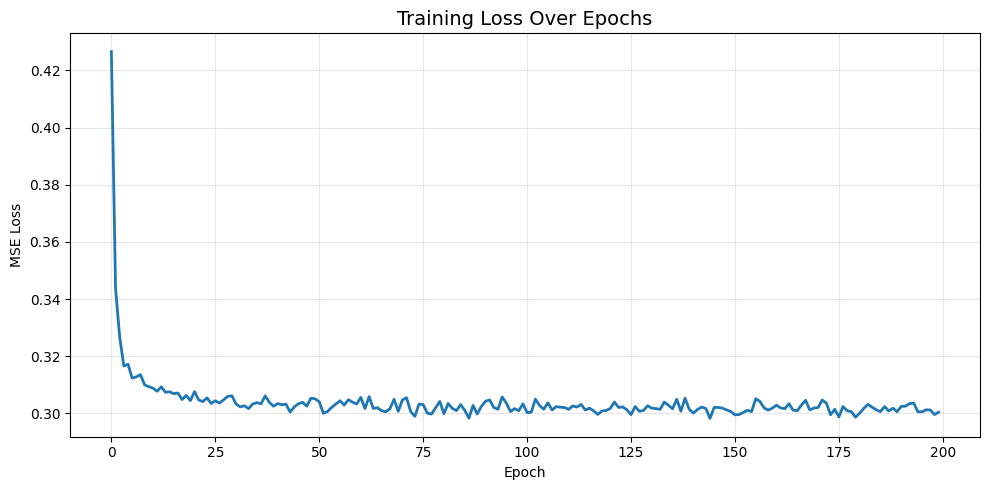

5. Visualizing results...


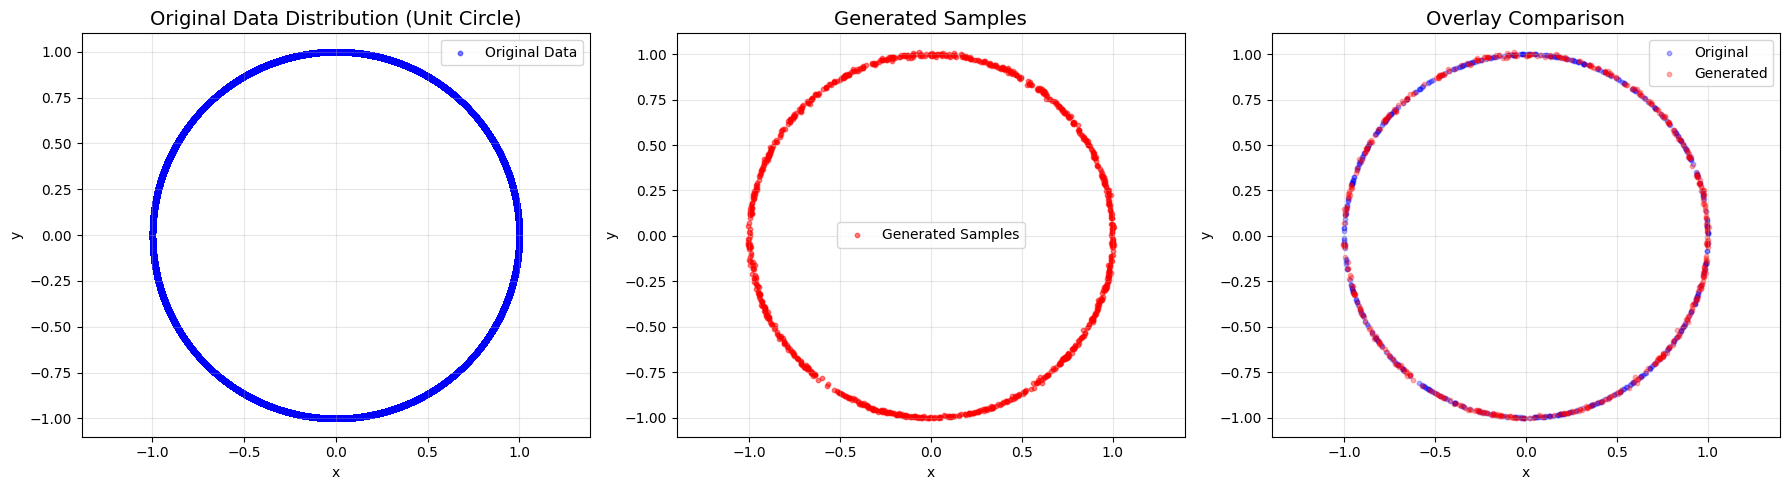

6. Visualizing denoising trajectories...


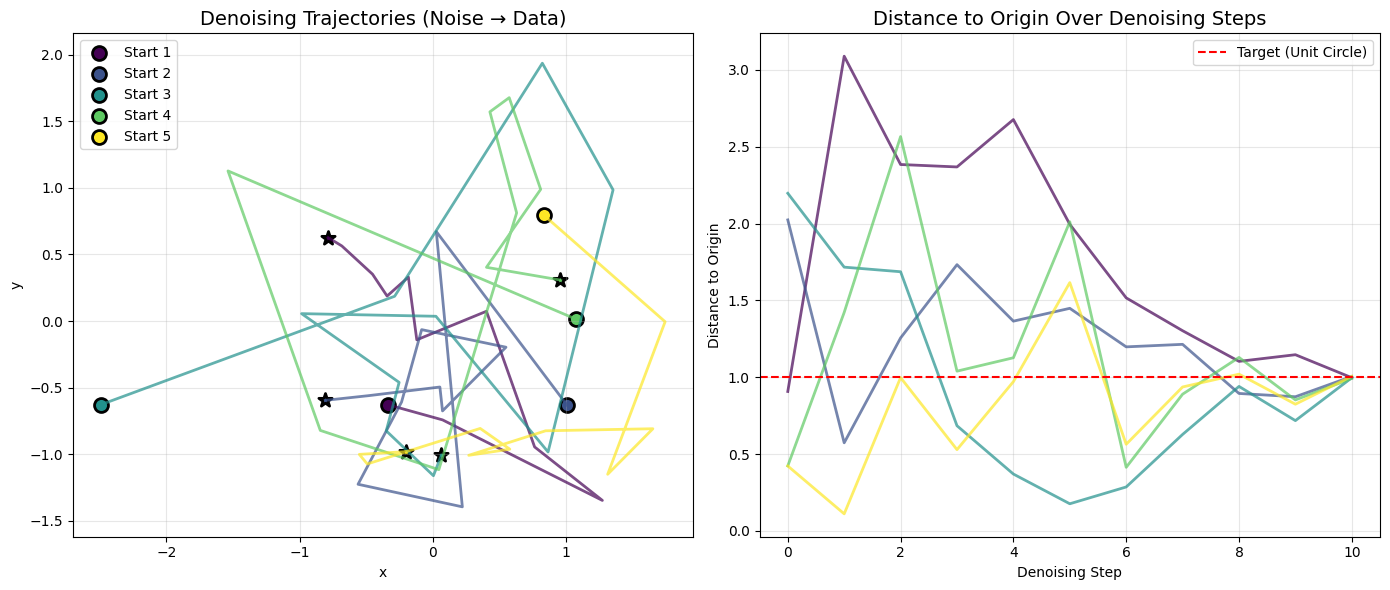


✓ 2D Experiment Complete!


EXPERIMENT 2: MNIST DIGIT GENERATION

1. Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.89MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.93MB/s]


2. Initializing model and scheduler...
3. Training model...


Epoch 1/200: 100%|██████████| 235/235 [00:48<00:00,  4.83it/s, loss=0.104]


Epoch 1: Average Loss = 0.288032


Epoch 2/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0896]


Epoch 2: Average Loss = 0.097321


Epoch 3/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0891]


Epoch 3: Average Loss = 0.089765


Epoch 4/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0943]


Epoch 4: Average Loss = 0.087830


Epoch 5/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0702]


Epoch 5: Average Loss = 0.085617


Epoch 6/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.081]


Epoch 6: Average Loss = 0.085540


Epoch 7/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0697]


Epoch 7: Average Loss = 0.084048


Epoch 8/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0846]


Epoch 8: Average Loss = 0.083119


Epoch 9/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0704]


Epoch 9: Average Loss = 0.079979


Epoch 10/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0538]


Epoch 10: Average Loss = 0.069761


Epoch 11/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0519]


Epoch 11: Average Loss = 0.055022


Epoch 12/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0514]


Epoch 12: Average Loss = 0.050057


Epoch 13/200: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.042]


Epoch 13: Average Loss = 0.047866


Epoch 14/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0439]


Epoch 14: Average Loss = 0.046472


Epoch 15/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.037]


Epoch 15: Average Loss = 0.045600


Epoch 16/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0475]


Epoch 16: Average Loss = 0.045198


Epoch 17/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0463]


Epoch 17: Average Loss = 0.044615


Epoch 18/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0445]


Epoch 18: Average Loss = 0.043769


Epoch 19/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0377]


Epoch 19: Average Loss = 0.043257


Epoch 20/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0433]


Epoch 20: Average Loss = 0.043163


Epoch 21/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0382]


Epoch 21: Average Loss = 0.042730


Epoch 22/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0431]


Epoch 22: Average Loss = 0.042265


Epoch 23/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0439]


Epoch 23: Average Loss = 0.042389


Epoch 24/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0402]


Epoch 24: Average Loss = 0.042135


Epoch 25/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0498]


Epoch 25: Average Loss = 0.041711


Epoch 26/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.039]


Epoch 26: Average Loss = 0.041786


Epoch 27/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0443]


Epoch 27: Average Loss = 0.041257


Epoch 28/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0401]


Epoch 28: Average Loss = 0.041260


Epoch 29/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0376]


Epoch 29: Average Loss = 0.040696


Epoch 30/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0388]


Epoch 30: Average Loss = 0.040726


Epoch 31/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0411]


Epoch 31: Average Loss = 0.040431


Epoch 32/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0461]


Epoch 32: Average Loss = 0.040290


Epoch 33/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.04]


Epoch 33: Average Loss = 0.040578


Epoch 34/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0389]


Epoch 34: Average Loss = 0.040069


Epoch 35/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0424]


Epoch 35: Average Loss = 0.039812


Epoch 36/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0438]


Epoch 36: Average Loss = 0.039504


Epoch 37/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0495]


Epoch 37: Average Loss = 0.039778


Epoch 38/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0294]


Epoch 38: Average Loss = 0.039380


Epoch 39/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0439]


Epoch 39: Average Loss = 0.039630


Epoch 40/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0361]


Epoch 40: Average Loss = 0.039224


Epoch 41/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0359]


Epoch 41: Average Loss = 0.039310


Epoch 42/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0414]


Epoch 42: Average Loss = 0.039216


Epoch 43/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0357]


Epoch 43: Average Loss = 0.038921


Epoch 44/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0411]


Epoch 44: Average Loss = 0.038818


Epoch 45/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0363]


Epoch 45: Average Loss = 0.038595


Epoch 46/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0353]


Epoch 46: Average Loss = 0.038820


Epoch 47/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0365]


Epoch 47: Average Loss = 0.038663


Epoch 48/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0404]


Epoch 48: Average Loss = 0.038814


Epoch 49/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0368]


Epoch 49: Average Loss = 0.038288


Epoch 50/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.034]


Epoch 50: Average Loss = 0.038293


Epoch 51/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0406]


Epoch 51: Average Loss = 0.038266


Epoch 52/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0344]


Epoch 52: Average Loss = 0.038022


Epoch 53/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0387]


Epoch 53: Average Loss = 0.037864


Epoch 54/200: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.0319]


Epoch 54: Average Loss = 0.038044


Epoch 55/200: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.0377]


Epoch 55: Average Loss = 0.038041


Epoch 56/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0402]


Epoch 56: Average Loss = 0.038105


Epoch 57/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0352]


Epoch 57: Average Loss = 0.037747


Epoch 58/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.037]


Epoch 58: Average Loss = 0.037725


Epoch 59/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0353]


Epoch 59: Average Loss = 0.037965


Epoch 60/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0323]


Epoch 60: Average Loss = 0.037594


Epoch 61/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0367]


Epoch 61: Average Loss = 0.037598


Epoch 62/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0316]


Epoch 62: Average Loss = 0.037566


Epoch 63/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0358]


Epoch 63: Average Loss = 0.037667


Epoch 64/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0365]


Epoch 64: Average Loss = 0.036995


Epoch 65/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0392]


Epoch 65: Average Loss = 0.037483


Epoch 66/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0402]


Epoch 66: Average Loss = 0.037237


Epoch 67/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0353]


Epoch 67: Average Loss = 0.037150


Epoch 68/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0337]


Epoch 68: Average Loss = 0.037099


Epoch 69/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0445]


Epoch 69: Average Loss = 0.037351


Epoch 70/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.037]


Epoch 70: Average Loss = 0.036932


Epoch 71/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0372]


Epoch 71: Average Loss = 0.036808


Epoch 72/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0339]


Epoch 72: Average Loss = 0.036924


Epoch 73/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0403]


Epoch 73: Average Loss = 0.036887


Epoch 74/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0405]


Epoch 74: Average Loss = 0.036885


Epoch 75/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0365]


Epoch 75: Average Loss = 0.037066


Epoch 76/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0369]


Epoch 76: Average Loss = 0.036817


Epoch 77/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.035]


Epoch 77: Average Loss = 0.036850


Epoch 78/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0351]


Epoch 78: Average Loss = 0.036753


Epoch 79/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0344]


Epoch 79: Average Loss = 0.036576


Epoch 80/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0394]


Epoch 80: Average Loss = 0.036571


Epoch 81/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0347]


Epoch 81: Average Loss = 0.036379


Epoch 82/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0312]


Epoch 82: Average Loss = 0.036588


Epoch 83/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0311]


Epoch 83: Average Loss = 0.036601


Epoch 84/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0292]


Epoch 84: Average Loss = 0.036513


Epoch 85/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0369]


Epoch 85: Average Loss = 0.036792


Epoch 86/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0351]


Epoch 86: Average Loss = 0.036513


Epoch 87/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0358]


Epoch 87: Average Loss = 0.036352


Epoch 88/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0365]


Epoch 88: Average Loss = 0.036414


Epoch 89/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0372]


Epoch 89: Average Loss = 0.036431


Epoch 90/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0388]


Epoch 90: Average Loss = 0.036235


Epoch 91/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0417]


Epoch 91: Average Loss = 0.036287


Epoch 92/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0337]


Epoch 92: Average Loss = 0.036262


Epoch 93/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0377]


Epoch 93: Average Loss = 0.036238


Epoch 94/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0345]


Epoch 94: Average Loss = 0.036147


Epoch 95/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0401]


Epoch 95: Average Loss = 0.036178


Epoch 96/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0332]


Epoch 96: Average Loss = 0.036204


Epoch 97/200: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.0318]


Epoch 97: Average Loss = 0.036423


Epoch 98/200: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.0406]


Epoch 98: Average Loss = 0.035837


Epoch 99/200: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.0379]


Epoch 99: Average Loss = 0.036120


Epoch 100/200: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.0315]


Epoch 100: Average Loss = 0.036155


>>> EPOCH 100 REACHED. Saving Checkpoint and Generating Samples... <<<
✓ Model saved to 'model_epoch_100.pth'


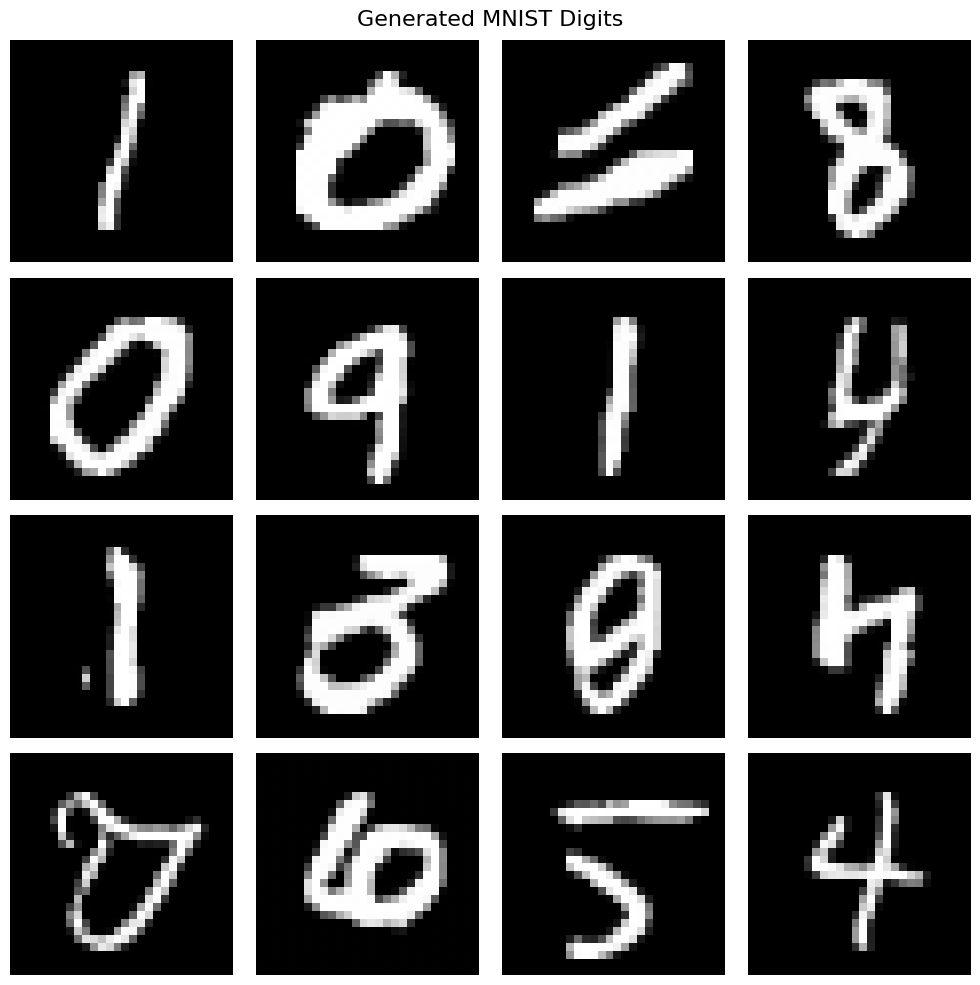

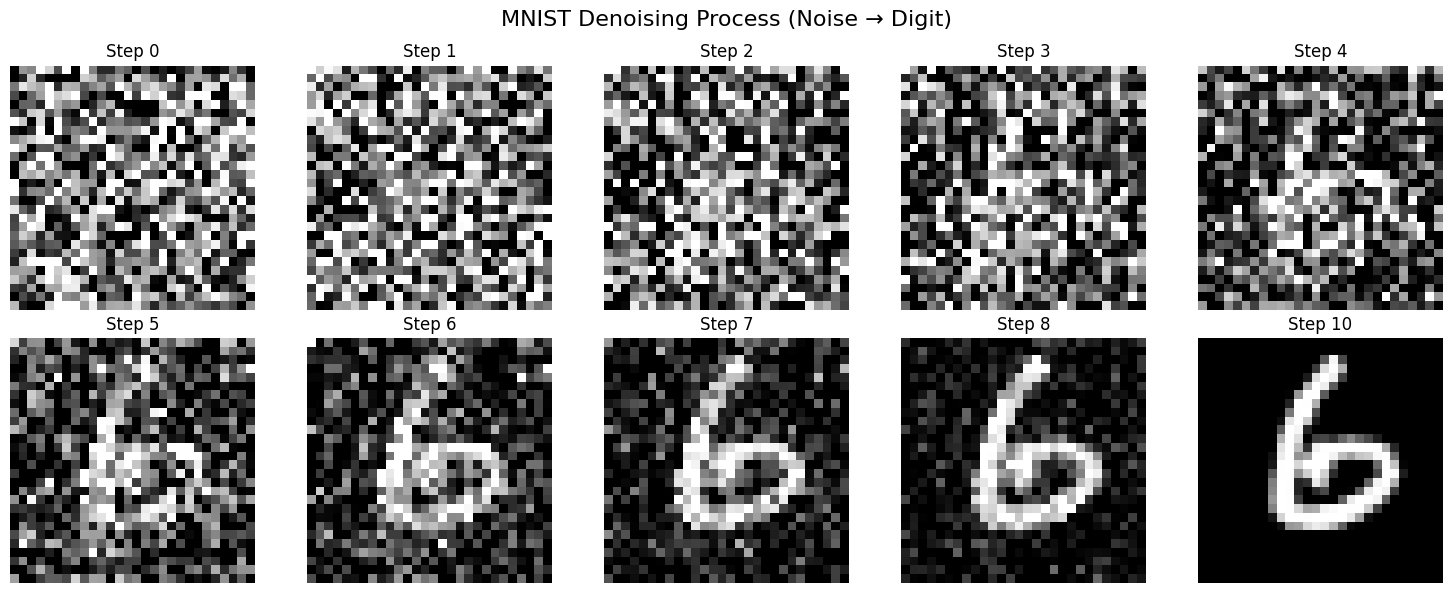

>>> Resuming training to 200...



Epoch 101/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0357]


Epoch 101: Average Loss = 0.036070


Epoch 102/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0354]


Epoch 102: Average Loss = 0.036428


Epoch 103/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.042]


Epoch 103: Average Loss = 0.036168


Epoch 104/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0384]


Epoch 104: Average Loss = 0.036112


Epoch 105/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.033]


Epoch 105: Average Loss = 0.035715


Epoch 106/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0354]


Epoch 106: Average Loss = 0.035751


Epoch 107/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0347]


Epoch 107: Average Loss = 0.035951


Epoch 108/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0333]


Epoch 108: Average Loss = 0.035758


Epoch 109/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0352]


Epoch 109: Average Loss = 0.035876


Epoch 110/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0349]


Epoch 110: Average Loss = 0.035956


Epoch 111/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0345]


Epoch 111: Average Loss = 0.035830


Epoch 112/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0309]


Epoch 112: Average Loss = 0.036158


Epoch 113/200: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.0379]


Epoch 113: Average Loss = 0.035740


Epoch 114/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0336]


Epoch 114: Average Loss = 0.035775


Epoch 115/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.035]


Epoch 115: Average Loss = 0.035446


Epoch 116/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0371]


Epoch 116: Average Loss = 0.035549


Epoch 117/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0388]


Epoch 117: Average Loss = 0.035769


Epoch 118/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0305]


Epoch 118: Average Loss = 0.035730


Epoch 119/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0367]


Epoch 119: Average Loss = 0.035748


Epoch 120/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0362]


Epoch 120: Average Loss = 0.035671


Epoch 121/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0359]


Epoch 121: Average Loss = 0.035544


Epoch 122/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0355]


Epoch 122: Average Loss = 0.035833


Epoch 123/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0362]


Epoch 123: Average Loss = 0.035560


Epoch 124/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0333]


Epoch 124: Average Loss = 0.035305


Epoch 125/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0385]


Epoch 125: Average Loss = 0.035458


Epoch 126/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.029]


Epoch 126: Average Loss = 0.035545


Epoch 127/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0359]


Epoch 127: Average Loss = 0.035654


Epoch 128/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0302]


Epoch 128: Average Loss = 0.035715


Epoch 129/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0438]


Epoch 129: Average Loss = 0.035534


Epoch 130/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0327]


Epoch 130: Average Loss = 0.035680


Epoch 131/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0332]


Epoch 131: Average Loss = 0.035262


Epoch 132/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0379]


Epoch 132: Average Loss = 0.035256


Epoch 133/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0367]


Epoch 133: Average Loss = 0.035351


Epoch 134/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0382]


Epoch 134: Average Loss = 0.035292


Epoch 135/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.037]


Epoch 135: Average Loss = 0.035536


Epoch 136/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0381]


Epoch 136: Average Loss = 0.035328


Epoch 137/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0402]


Epoch 137: Average Loss = 0.035401


Epoch 138/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0367]


Epoch 138: Average Loss = 0.035283


Epoch 139/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.033]


Epoch 139: Average Loss = 0.035275


Epoch 140/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0376]


Epoch 140: Average Loss = 0.035457


Epoch 141/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.033]


Epoch 141: Average Loss = 0.035228


Epoch 142/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0353]


Epoch 142: Average Loss = 0.035390


Epoch 143/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0403]


Epoch 143: Average Loss = 0.035478


Epoch 144/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0346]


Epoch 144: Average Loss = 0.035294


Epoch 145/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0326]


Epoch 145: Average Loss = 0.035233


Epoch 146/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0274]


Epoch 146: Average Loss = 0.035337


Epoch 147/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0352]


Epoch 147: Average Loss = 0.035156


Epoch 148/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0355]


Epoch 148: Average Loss = 0.035147


Epoch 149/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.034]


Epoch 149: Average Loss = 0.035215


Epoch 150/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0372]


Epoch 150: Average Loss = 0.035199


Epoch 151/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0333]


Epoch 151: Average Loss = 0.035201


Epoch 152/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0307]


Epoch 152: Average Loss = 0.035006


Epoch 153/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0332]


Epoch 153: Average Loss = 0.035052


Epoch 154/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0317]


Epoch 154: Average Loss = 0.035061


Epoch 155/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0348]


Epoch 155: Average Loss = 0.035127


Epoch 156/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.04]


Epoch 156: Average Loss = 0.035106


Epoch 157/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0352]


Epoch 157: Average Loss = 0.035093


Epoch 158/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.034]


Epoch 158: Average Loss = 0.035035


Epoch 159/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0362]


Epoch 159: Average Loss = 0.034936


Epoch 160/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0322]


Epoch 160: Average Loss = 0.035264


Epoch 161/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0333]


Epoch 161: Average Loss = 0.035018


Epoch 162/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0399]


Epoch 162: Average Loss = 0.035069


Epoch 163/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0418]


Epoch 163: Average Loss = 0.035155


Epoch 164/200: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0369]


Epoch 164: Average Loss = 0.034931


Epoch 165/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0305]


Epoch 165: Average Loss = 0.034945


Epoch 166/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0361]


Epoch 166: Average Loss = 0.034973


Epoch 167/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0335]


Epoch 167: Average Loss = 0.034997


Epoch 168/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.038]


Epoch 168: Average Loss = 0.035033


Epoch 169/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0374]


Epoch 169: Average Loss = 0.035181


Epoch 170/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0362]


Epoch 170: Average Loss = 0.035032


Epoch 171/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0338]


Epoch 171: Average Loss = 0.034947


Epoch 172/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0304]


Epoch 172: Average Loss = 0.034917


Epoch 173/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0354]


Epoch 173: Average Loss = 0.034967


Epoch 174/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0331]


Epoch 174: Average Loss = 0.035194


Epoch 175/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0382]


Epoch 175: Average Loss = 0.035048


Epoch 176/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0328]


Epoch 176: Average Loss = 0.034918


Epoch 177/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0376]


Epoch 177: Average Loss = 0.034850


Epoch 178/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0332]


Epoch 178: Average Loss = 0.034853


Epoch 179/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0335]


Epoch 179: Average Loss = 0.034888


Epoch 180/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0421]


Epoch 180: Average Loss = 0.034904


Epoch 181/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0391]


Epoch 181: Average Loss = 0.034919


Epoch 182/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0369]


Epoch 182: Average Loss = 0.034807


Epoch 183/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0257]


Epoch 183: Average Loss = 0.034585


Epoch 184/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.039]


Epoch 184: Average Loss = 0.034830


Epoch 185/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0354]


Epoch 185: Average Loss = 0.034804


Epoch 186/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0341]


Epoch 186: Average Loss = 0.034875


Epoch 187/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0289]


Epoch 187: Average Loss = 0.034911


Epoch 188/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0406]


Epoch 188: Average Loss = 0.034961


Epoch 189/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.038]


Epoch 189: Average Loss = 0.034785


Epoch 190/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0405]


Epoch 190: Average Loss = 0.034729


Epoch 191/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0365]


Epoch 191: Average Loss = 0.034741


Epoch 192/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0347]


Epoch 192: Average Loss = 0.034848


Epoch 193/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0358]


Epoch 193: Average Loss = 0.034859


Epoch 194/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0312]


Epoch 194: Average Loss = 0.034643


Epoch 195/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0358]


Epoch 195: Average Loss = 0.034889


Epoch 196/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0377]


Epoch 196: Average Loss = 0.034713


Epoch 197/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0323]


Epoch 197: Average Loss = 0.034641


Epoch 198/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0372]


Epoch 198: Average Loss = 0.034684


Epoch 199/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0411]


Epoch 199: Average Loss = 0.034750


Epoch 200/200: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s, loss=0.0349]


Epoch 200: Average Loss = 0.034540

4. Plotting training losses...


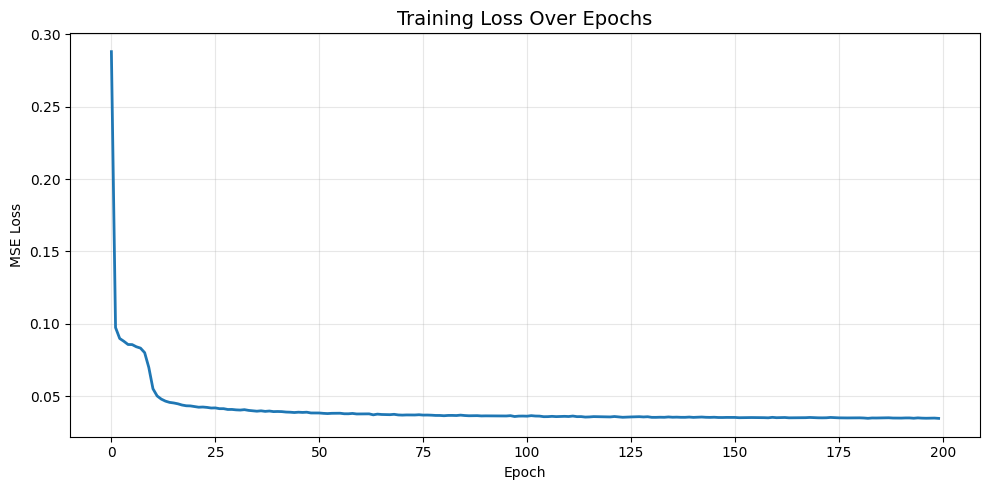

5. Visualizing generated digits...


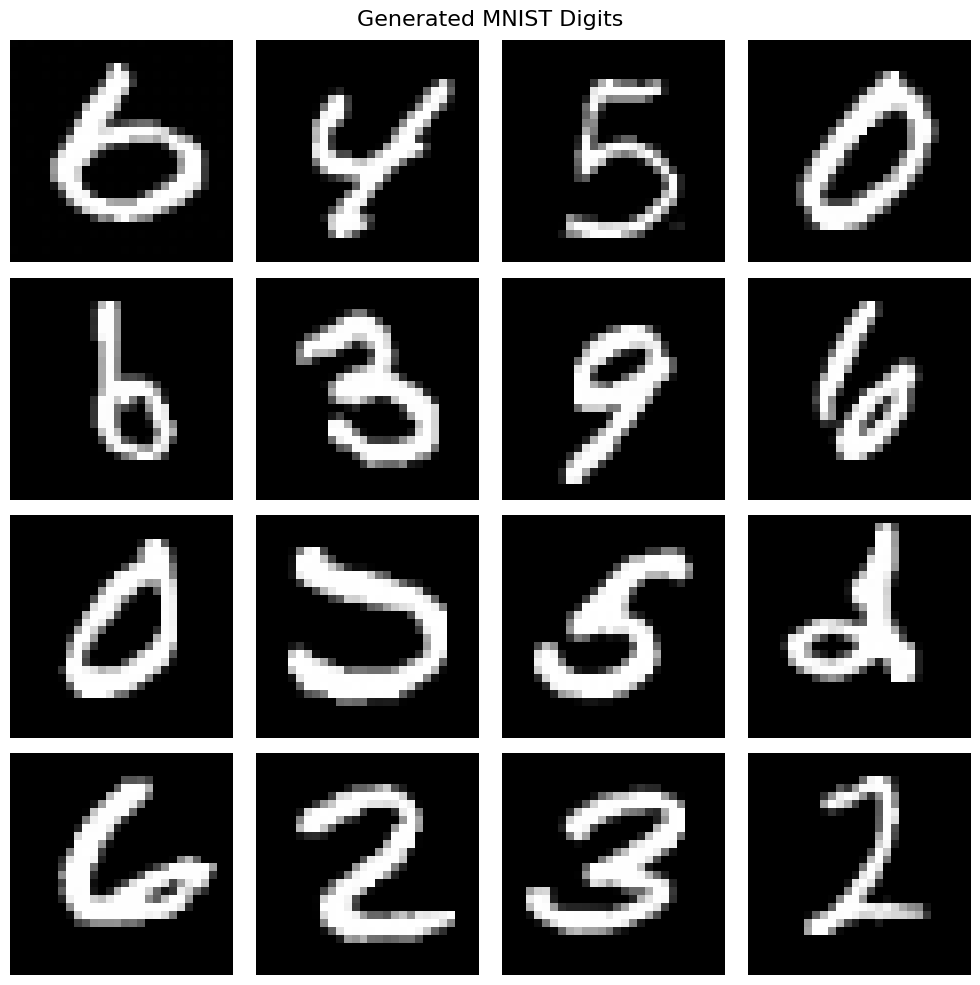

6. Visualizing denoising process...


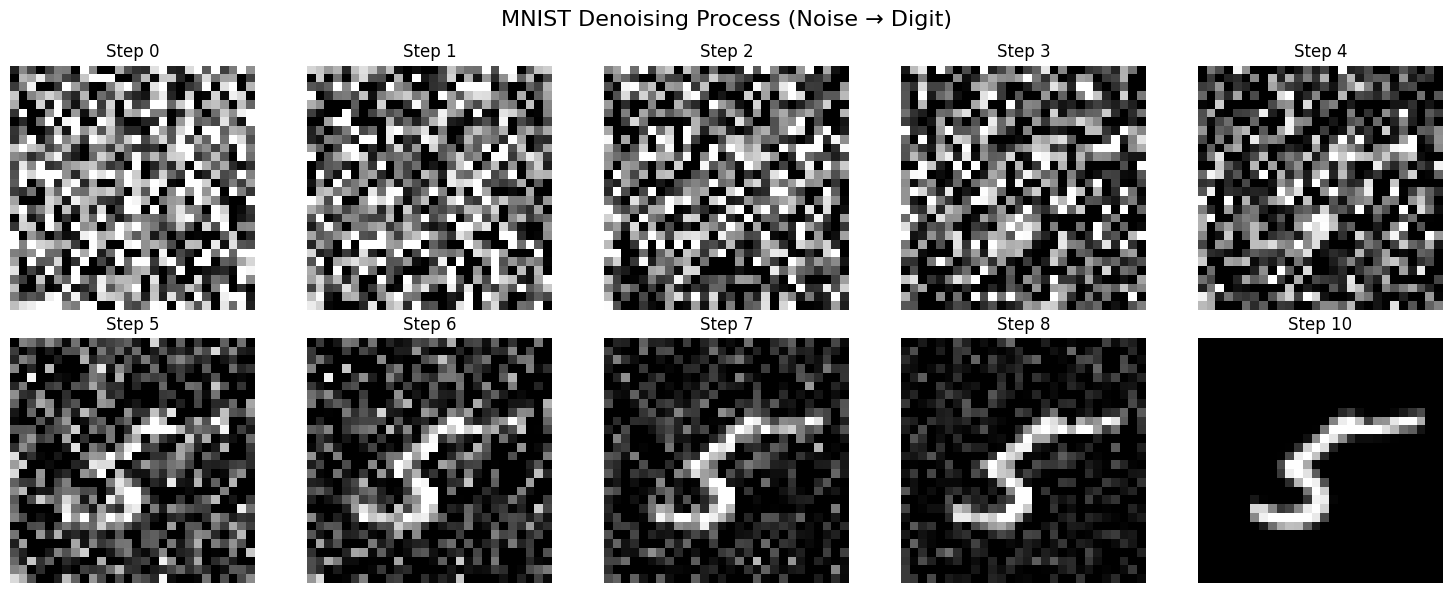


✓ MNIST Experiment Complete!

ALL EXPERIMENTS COMPLETE!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import warnings
from google.colab import runtime
warnings.filterwarnings('ignore')

#==============================================================================
# PART 3: DATASET GENERATORS
#==============================================================================

class Synthetic2DDataset(Dataset):
    """2D Synthetic dataset: y = x/||x|| where x ~ N(0, I)"""

    def __init__(self, num_samples=10000):
        # Sample from N(0, I)
        x = np.random.randn(num_samples, 2)

        # Normalize to unit circle: y = x / ||x||
        norms = np.linalg.norm(x, axis=1, keepdims=True)
        y = x / norms

        self.data = torch.FloatTensor(y)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def get_mnist_dataloader(batch_size=64, train=True):
    """Load MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    dataset = datasets.MNIST(
        root='./data',
        train=train,
        download=True,
        transform=transform
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=train,
        num_workers=2
    )

    return dataloader

#==============================================================================
# PART 7: MAIN EXECUTION
#==============================================================================

def main_2d_experiment():
    """Main function for 2D synthetic data experiment"""
    print("="*80)
    print("EXPERIMENT 1: 2D SYNTHETIC DATA (Unit Circle)")
    print("="*80)

    # Create dataset
    print("\n1. Creating 2D synthetic dataset...")
    dataset = Synthetic2DDataset(num_samples=100000)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Create model and scheduler
    print("2. Initializing model and scheduler...")
    model = SimpleMLP(input_dim=2, hidden_dim=128)
    scheduler = DDPMScheduler(num_timesteps=1000, schedule="cosine")
    # Move scheduler's internal tensors to the correct device
    scheduler.betas = scheduler.betas.to(device)
    scheduler.alphas = scheduler.alphas.to(device)
    scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)
    scheduler.alphas_cumprod_prev = scheduler.alphas_cumprod_prev.to(device)
    scheduler.sqrt_alphas_cumprod = scheduler.sqrt_alphas_cumprod.to(device)
    scheduler.sqrt_one_minus_alphas_cumprod = scheduler.sqrt_one_minus_alphas_cumprod.to(device)
    scheduler.sqrt_recip_alphas = scheduler.sqrt_recip_alphas.to(device)
    scheduler.posterior_variance = scheduler.posterior_variance.to(device)

    # Train model
    print("3. Training model...")
    losses, ema_model_2d = train_ddpm(model, dataloader, scheduler, num_epochs=200, lr=1e-3, experiment='2d')

    # Plot training losses
    print("\n4. Plotting training losses...")
    plot_training_losses(losses)

    # Visualize results
    print("5. Visualizing results...")
    visualize_2d_results(ema_model_2d, scheduler, dataset, num_samples=1000)

    # Visualize denoising trajectories
    print("6. Visualizing denoising trajectories...")
    visualize_denoising_trajectory(ema_model_2d, scheduler, num_trajectories=5)

    print("\n✓ 2D Experiment Complete!")
    return ema_model_2d, scheduler


def main_mnist_experiment():
    """Main function for MNIST experiment"""
    print("="*80)
    print("EXPERIMENT 2: MNIST DIGIT GENERATION")
    print("="*80)

    # Load MNIST dataset
    print("\n1. Loading MNIST dataset...")
    dataloader = get_mnist_dataloader(batch_size=256, train=True)

    # Create model and scheduler
    print("2. Initializing model and scheduler...")
    #model = BetterUNet(in_channels=1)
    model = MiniDiT(in_channels=1, patch_size=2, hidden_size=256, depth=8).to(device)
    #model = ConvNextUNet(in_channels=1 )
    scheduler = DDPMScheduler(num_timesteps=1000, schedule="cosine")
    # Move scheduler's internal tensors to the correct device
    scheduler.betas = scheduler.betas.to(device)
    scheduler.alphas = scheduler.alphas.to(device)
    scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)
    scheduler.alphas_cumprod_prev = scheduler.alphas_cumprod_prev.to(device)
    scheduler.sqrt_alphas_cumprod = scheduler.sqrt_alphas_cumprod.to(device)
    scheduler.sqrt_one_minus_alphas_cumprod = scheduler.sqrt_one_minus_alphas_cumprod.to(device)
    scheduler.sqrt_recip_alphas = scheduler.sqrt_recip_alphas.to(device)
    scheduler.posterior_variance = scheduler.posterior_variance.to(device)

    # Capture the EMA model
    print("3. Training model...")
    losses, ema_model = train_ddpm(model, dataloader, scheduler, num_epochs=200, lr=1e-3, experiment='mnist') # 50 epochs is enough with EMA

    # Plot training losses
    print("\n4. Plotting training losses...")
    plot_training_losses(losses)


   # Use ema_model for visualization
    print("5. Visualizing generated digits...")
    visualize_mnist_results(ema_model, scheduler, num_samples=16)

    print("6. Visualizing denoising process...")
    visualize_mnist_denoising_process(ema_model, scheduler)
    # Train model
    #print("3. Training model...")
    #losses = train_ddpm(model, dataloader, scheduler, num_epochs=50, lr=1e-4)


    # Visualize results
    #print("5. Visualizing generated digits...")
    #visualize_mnist_results(model, scheduler, num_samples=16)

    # Visualize denoising process
    #print("6. Visualizing denoising process...")
    #visualize_mnist_denoising_process(model, scheduler)

    print("\n✓ MNIST Experiment Complete!")
    return model, scheduler


# Run experiments
if __name__ == "__main__":
    print("DENOISING DIFFUSION PROBABILISTIC MODEL (DDPM)")
    print("Implementation for 2D Synthetic Data and MNIST")
    print()

    # Experiment 1: 2D Synthetic Data
    model_2d, scheduler_2d = main_2d_experiment()

    print("\n" + "="*80 + "\n")

    # Experiment 2: MNIST
    model_mnist, scheduler_mnist = main_mnist_experiment()

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETE!")
    print("="*80)
    runtime.unassign()
